In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from rnndatasets import sequentialmnist as mnist

In [2]:
def orthogonal_regulariser(beta=1.0):
    def o_r(mat):
        if len(mat.get_shape()) != 2:
            return None
        cov = tf.matmul(mat, mat, transpose_b=True)  # careful which way
        eye = tf.constant(np.eye(mat.get_shape()[0].value), dtype=tf.float32)
        return tf.reduce_sum(tf.square(cov - eye)) * beta
    return o_r

In [3]:
data, targets = mnist.get_data('train', 60000)
vdata, vtargets = mnist.get_data('test', 10000)

In [4]:
def affine(input_var, new_size, scope=None):
    with tf.variable_scope(scope or 'affine'):
        in_size = input_var.get_shape()[1].value
        weights = tf.get_variable('weights', shape=[in_size, new_size])
        bias = tf.get_variable('bias', shape=[new_size], initializer=tf.constant_initializer(0.0))
        
        return tf.nn.bias_add(tf.matmul(input_var, weights), bias)

In [5]:
def deep_ff_net(input_var, depth, width, num_outputs, nonlinearity=tf.nn.relu):
    
    layer_in = input_var
    
    for i, size in enumerate([width] * depth):
        layer_in = affine(layer_in, size, 'layer_{}'.format(i))
        layer_in = nonlinearity(layer_in)
    
    out = affine(layer_in, num_outputs, 'output_layer')
    
    return out

In [6]:
def batch_iter(data, labels, batch_size):
    num_batches = data.shape[0] // batch_size
    
    idcs = np.arange(len(data))
    np.random.shuffle(idcs)
    
    for i in range(num_batches):
        batch_idcs = idcs[i*batch_size:(i+1)*batch_size]
        yield data[batch_idcs,...], labels[batch_idcs]

In [7]:
tf.reset_default_graph()

DEPTH = 2
WIDTH = 50

inputs = tf.placeholder(tf.float32, name='inputs', shape=[None, 784])
labels = tf.placeholder(tf.int32, name='labels', shape=[None])

with tf.variable_scope('deep_relu'):
    relu_out = deep_ff_net(inputs, DEPTH, WIDTH, 10)
    
    relu_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
        relu_out, labels)
    relu_loss = tf.reduce_mean(relu_loss)
    
    relu_opt = tf.train.RMSPropOptimizer(0.001)
    relu_train = relu_opt.minimize(relu_loss)
    
    relu_acc = tf.contrib.metrics.accuracy(
        tf.cast(tf.argmax(relu_out, 1), tf.int32), labels)

with tf.variable_scope('deep_linear', regularizer=orthogonal_regulariser()):  # with squared error, for maximum linearness
    lin_out = deep_ff_net(inputs, DEPTH, WIDTH, 10)
    
    lin_loss = tf.squared_difference(
        lin_out, tf.one_hot(labels, 10))
    lin_loss = tf.reduce_mean(lin_loss) + tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    
    lin_opt = tf.train.RMSPropOptimizer(0.001)
    lin_train = lin_opt.minimize(lin_loss)
    
    lin_acc = tf.contrib.metrics.accuracy(
        tf.cast(tf.argmax(lin_out, 1), tf.int32), labels)

all_trains = tf.group(relu_train, lin_train)

In [8]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [9]:
data = data.reshape((-1, 784))
vdata = vdata.reshape((-1, 784))

In [10]:
BATCH_SIZE = 100

losses = {'relu': [],
          'linear': []}
vlosses = {'relu': [],
           'linear': []}

for epoch in range(50):
    epoch_losses = {key: 0 for key in losses}
    epoch_steps = 0
    for batch_data, batch_labels in batch_iter(data, targets, BATCH_SIZE):
        rloss, lloss, _ = sess.run(
            [relu_acc, lin_acc, all_trains],
            {inputs: batch_data,
             labels: batch_labels})
        epoch_losses['linear'] += lloss
        epoch_losses['relu'] += rloss
        epoch_steps += 1
    print('\r{}~relu acc: {}, linear acc: {}'.format(
            epoch+1, epoch_losses['relu'] / epoch_steps,
            epoch_losses['linear'] / epoch_steps), end='',
           flush=True)
    valid_accs = {key: 0 for key in losses}
    vepoch_steps = 0
    for batch_data, batch_labels in batch_iter(vdata, vtargets, BATCH_SIZE):
        rvalid, lvalid = sess.run(
            [relu_acc, lin_acc],
            {inputs: batch_data,
             labels: batch_labels})
        valid_accs['linear'] += lvalid
        valid_accs['relu'] += rvalid
        vepoch_steps += 1
    print('\r{}valid~relu acc: {}, linear acc: {}'.format(
            epoch+1, epoch_losses['relu'] / epoch_steps,
            epoch_losses['linear'] / epoch_steps), end='')
    
    for key in losses:
        losses[key].append(epoch_losses[key]/epoch_steps)
        vlosses[key].append(valid_accs[key]/vepoch_steps)
    

33valid~relu acc: 0.990400008459886, linear acc: 0.9322333365678788

KeyboardInterrupt: 

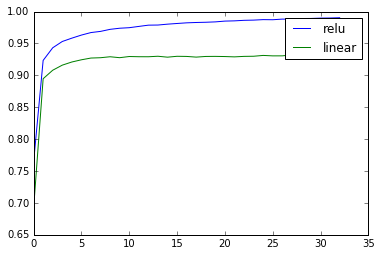

In [11]:
for key in losses:
    plt.plot(losses[key], label=key)
plt.legend()

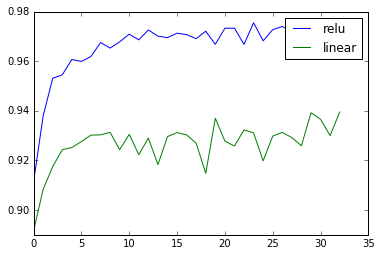

In [12]:
for key in vlosses:
    plt.plot(vlosses[key], label=key)
plt.legend()